In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
files = {'cr_loan2.csv': '/content/cr_loan2.csv.xls'}

def load_file_into_dataframe(file_name):
    df = pd.read_csv(files[file_name])
    return df

# Load data
cr_loan = load_file_into_dataframe('cr_loan2.csv')

# Display basic info
cr_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [3]:
cr_loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
### Encode Categorical Variables
# Initialize LabelEncoder for encoding categorical variables
label_encoders = {}

categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for col in categorical_columns:
    le = LabelEncoder()
    cr_loan[col] = le.fit_transform(cr_loan[col])
    label_encoders[col] = le

In [5]:
###Handle Missing Values
# Fill missing values in person_emp_length with the median
cr_loan['person_emp_length'].fillna(cr_loan['person_emp_length'].median(), inplace=True)

# Drop rows where loan_int_rate is missing
cr_loan.dropna(subset=['loan_int_rate'], inplace=True)

# Display missing values count after handling
print("Missing values after imputation and removal:")
print(cr_loan.isnull().sum())



Missing values after imputation and removal:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [6]:
### Drop Features with Low Standard Deviation
std_threshold = 0.3
low_std_columns = cr_loan.std()[cr_loan.std() < std_threshold].index
cr_loan = cr_loan.drop(columns=low_std_columns)



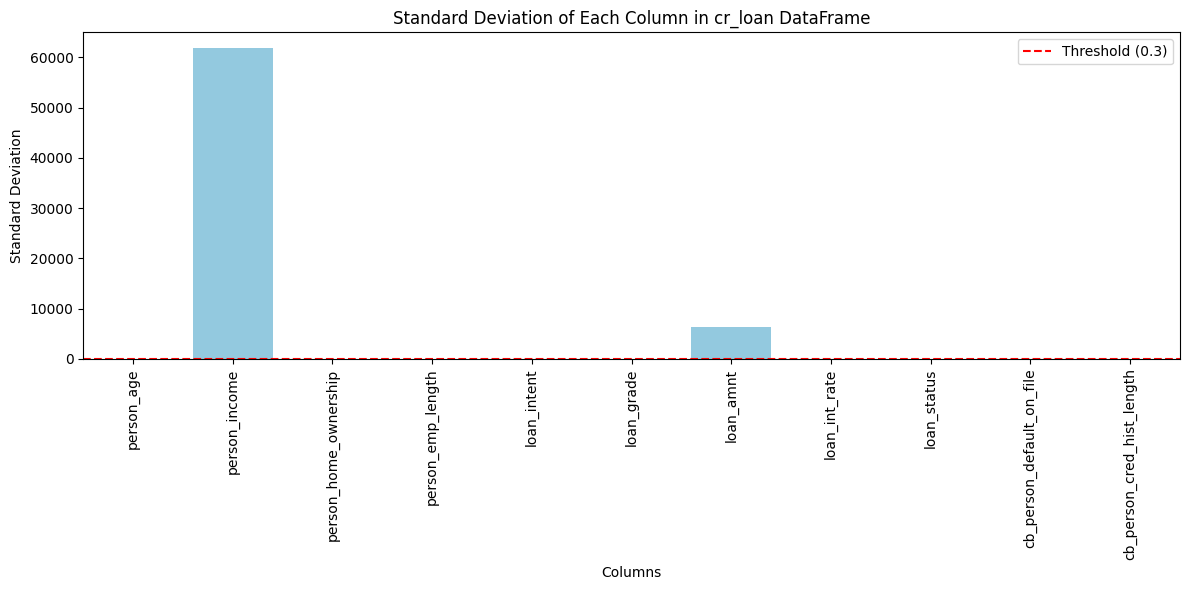

In [7]:
# Calculate standard deviation for each column
std_values = cr_loan.std()

# Plot standard deviation values
plt.figure(figsize=(12, 6))
sns.barplot(x=std_values.index, y=std_values.values, color='skyblue')

# Highlight columns with standard deviation below the threshold
plt.axhline(y=0.01, color='red', linestyle='--', label='Threshold (0.3)')

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Each Column in cr_loan DataFrame')
plt.xticks(rotation=90)  # Rotate column names for readability
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


In [8]:
# Drop Features with Low Standard Deviation
std_threshold = 0.01
low_std_columns = cr_loan.std()[cr_loan.std() < std_threshold].index

# Display columns with low variance
print("Columns with low standard deviation (below threshold of 0.01):")
print(low_std_columns.tolist())

# Drop low-variance columns
cr_loan = cr_loan.drop(columns=low_std_columns)

# Display the updated DataFrame
print("\nDataFrame after dropping low-variance columns:")
print(cr_loan)


Columns with low standard deviation (below threshold of 0.01):
[]

DataFrame after dropping low-variance columns:
       person_age  person_income  person_home_ownership  person_emp_length  \
0              22          59000                      3              123.0   
1              21           9600                      2                5.0   
2              25           9600                      0                1.0   
3              23          65500                      3                4.0   
4              24          54400                      3                8.0   
...           ...            ...                    ...                ...   
32576          57          53000                      0                1.0   
32577          54         120000                      0                4.0   
32578          65          76000                      3                3.0   
32579          56         150000                      0                5.0   
32580          66          4

In [9]:
### Calculate Variance Inflation Factor (VIF) for Numerical Features
numerical_features = cr_loan.select_dtypes(include=['float64', 'int64']).columns
X = cr_loan[numerical_features]

# Add constant to the data for VIF calculation
X = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print("Variance Inflation Factor (VIF) for each feature:")
print(vif_data)



Variance Inflation Factor (VIF) for each feature:
                       Feature        VIF
0                        const  93.951475
1                   person_age   3.944935
2                person_income   1.179424
3        person_home_ownership   1.152223
4            person_emp_length   1.096100
5                  loan_intent   1.007094
6                   loan_grade   8.547784
7                    loan_amnt   1.142640
8                loan_int_rate   7.894193
9                  loan_status   1.254097
10   cb_person_default_on_file   1.408047
11  cb_person_cred_hist_length   3.858767


In [10]:
# Drop features with high VIF (e.g., VIF > 8)
high_vif_features = vif_data[vif_data["VIF"] > 8]["Feature"].tolist()

# Check if 'const' is in the high_vif_features list and remove it if present
high_vif_features = [feature for feature in high_vif_features if feature != 'const']

# Now drop the high VIF features from the DataFrame
cr_loan = cr_loan.drop(columns=high_vif_features)

# Display the dropped features
print(f"Dropped features due to high VIF: {high_vif_features}")



Dropped features due to high VIF: ['loan_grade']


In [11]:
cr_loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,3,123.0,4,35000,16.02,1,1,3
1,21,9600,2,5.0,1,1000,11.14,0,0,2
2,25,9600,0,1.0,3,5500,12.87,1,0,3
3,23,65500,3,4.0,3,35000,15.23,1,0,2
4,24,54400,3,8.0,3,35000,14.27,1,1,4


In [12]:
# Drop 'loan_grade' from cr_loan and remove it from categorical_columns if present
cr_loan = cr_loan.drop(columns=['loan_grade'], errors='ignore')
categorical_columns = [col for col in categorical_columns if col != 'loan_grade']

# Function to calculate WoE and IV
def calc_woe_iv(df, feature, target):
    lst = pd.crosstab(df[feature], df[target], normalize='columns')
    lst = pd.DataFrame(lst).reset_index()

    # Adding a small value to avoid division by zero
    lst['WoE'] = np.log((lst[1] + 1e-10) / (lst[0] + 1e-10))
    lst['IV'] = (lst[1] - lst[0]) * lst['WoE']
    iv = lst['IV'].sum()

    return iv, lst

# Calculate IV for each categorical feature
iv_values = {}
for col in categorical_columns:
    iv, woe_table = calc_woe_iv(cr_loan, col, 'loan_status')
    iv_values[col] = iv

    # Optional: display WoE table for each feature
    print(f"\nWoE Table for {col}:")
    print(woe_table)

# Display IV values for each feature
print("\nInformation Value for each feature:")
for feature, iv in iv_values.items():
    print(f"{feature}: {iv}")




WoE Table for person_home_ownership:
loan_status  person_home_ownership         0         1       WoE        IV
0                                0  0.460110  0.238088 -0.658827  0.146274
1                                1  0.002913  0.004177  0.360434  0.000456
2                                2  0.095083  0.026145 -1.291098  0.089006
3                                3  0.441894  0.731590  0.504151  0.146051

WoE Table for loan_intent:
loan_status  loan_intent         0         1       WoE        IV
0                      0  0.145950  0.208230  0.355379  0.022133
1                      1  0.210556  0.156405 -0.297305  0.016099
2                      2  0.105517  0.133509  0.235293  0.006586
3                      3  0.173036  0.227568  0.273950  0.014939
4                      4  0.174079  0.156250 -0.108054  0.001927
5                      5  0.190861  0.118038 -0.480537  0.034994

WoE Table for cb_person_default_on_file:
loan_status  cb_person_default_on_file         0         1    

In [13]:
# Drop features with low IV (e.g., IV < 0.02)
low_iv_features = [feature for feature, iv in iv_values.items() if iv < 0.02]
cr_loan = cr_loan.drop(columns=low_iv_features)

# Display the dropped features
print(f"Dropped features due to low Information Value: {low_iv_features}")


Dropped features due to low Information Value: []


<class 'pandas.core.frame.DataFrame'>
Index: 29465 entries, 0 to 32580
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  29465 non-null  int64  
 1   person_income               29465 non-null  int64  
 2   person_home_ownership       29465 non-null  int64  
 3   person_emp_length           29465 non-null  float64
 4   loan_intent                 29465 non-null  int64  
 5   loan_amnt                   29465 non-null  int64  
 6   loan_int_rate               29465 non-null  float64
 7   loan_status                 29465 non-null  int64  
 8   cb_person_default_on_file   29465 non-null  int64  
 9   cb_person_cred_hist_length  29465 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 2.5 MB
                            person_age  person_income  person_home_ownership  \
person_age                    1.000000       0.177265              -0.033716   
pe

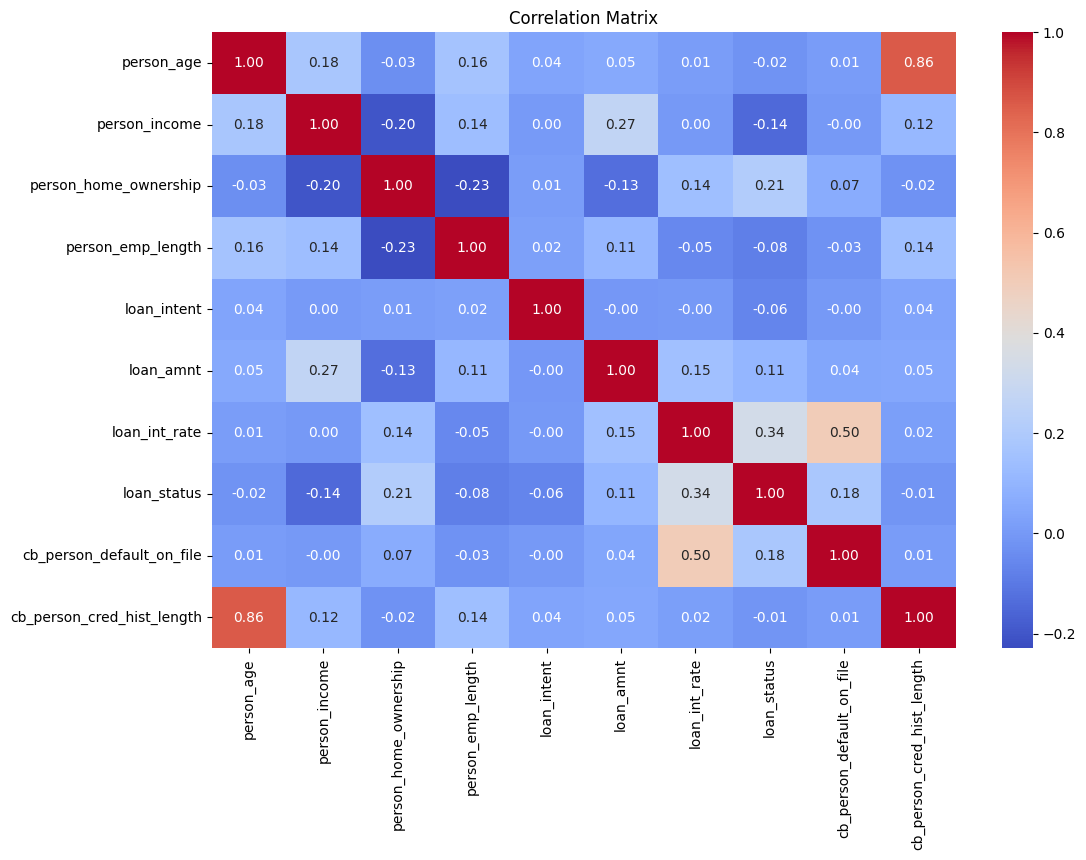

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,3,123.0,4,35000,16.02,1,1,3
1,21,9600,2,5.0,1,1000,11.14,0,0,2
2,25,9600,0,1.0,3,5500,12.87,1,0,3
3,23,65500,3,4.0,3,35000,15.23,1,0,2
4,24,54400,3,8.0,3,35000,14.27,1,1,4


In [14]:
# Review the cleaned dataset
cr_loan.info()

numerical_features = cr_loan.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = cr_loan[numerical_features].corr()
print(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# Final cleaned data
cr_loan_cleaned = cr_loan
cr_loan_cleaned.head()

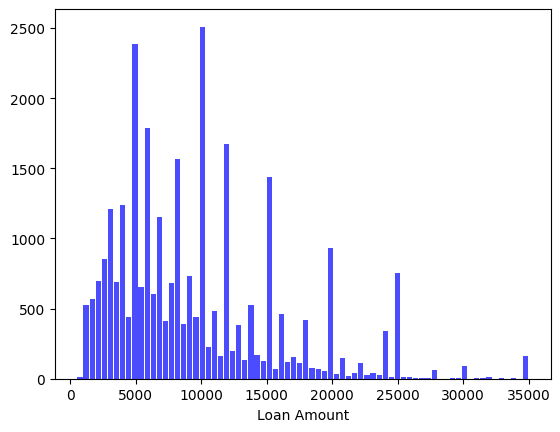

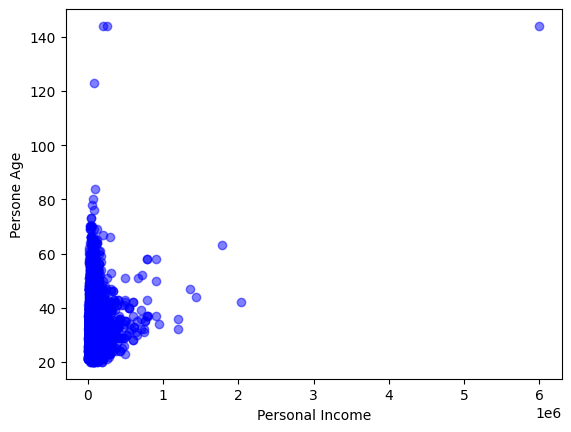

In [15]:
### Explore the credit data
# Look at the distribution of loan amounts with a histogram
n, bins, patches = plt.hist(x=cr_loan['loan_amnt'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Loan Amount")
plt.show()


# Plot a scatter plot of income against age
plt.scatter(cr_loan['person_income'], cr_loan['person_age'],c='blue', alpha=0.5)
plt.xlabel('Personal Income')
plt.ylabel('Persone Age')
plt.show()

In [16]:
cr_loan_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29465 entries, 0 to 32580
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  29465 non-null  int64  
 1   person_income               29465 non-null  int64  
 2   person_home_ownership       29465 non-null  int64  
 3   person_emp_length           29465 non-null  float64
 4   loan_intent                 29465 non-null  int64  
 5   loan_amnt                   29465 non-null  int64  
 6   loan_int_rate               29465 non-null  float64
 7   loan_status                 29465 non-null  int64  
 8   cb_person_default_on_file   29465 non-null  int64  
 9   cb_person_cred_hist_length  29465 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 2.5 MB


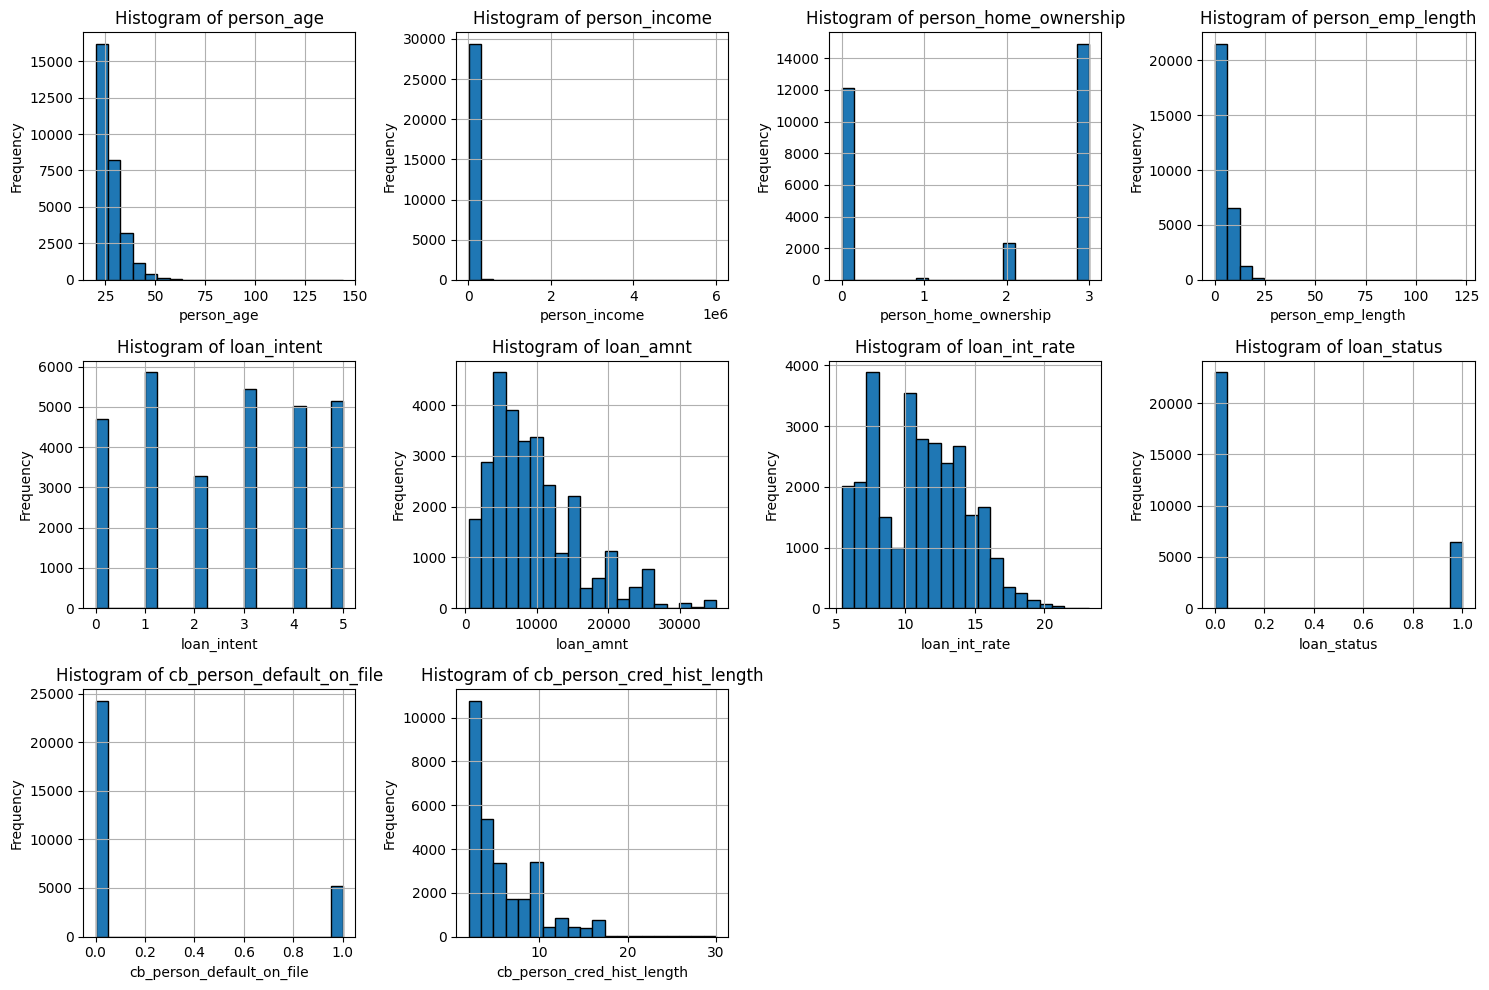

Summary Statistics for Numerical Features:
         person_age  person_income  person_home_ownership  person_emp_length  \
count  29465.000000   2.946500e+04            29465.00000       29465.000000   
mean      27.714712   6.602047e+04                1.67945           4.766537   
std        6.300193   6.190142e+04                1.43233           4.097976   
min       20.000000   4.000000e+03                0.00000           0.000000   
25%       23.000000   3.850000e+04                0.00000           2.000000   
50%       26.000000   5.500000e+04                3.00000           4.000000   
75%       30.000000   7.910000e+04                3.00000           7.000000   
max      144.000000   6.000000e+06                3.00000         123.000000   

        loan_intent     loan_amnt  loan_int_rate   loan_status  \
count  29465.000000  29465.000000   29465.000000  29465.000000   
mean       2.532089   9584.744612      11.011695      0.219379   
std        1.730246   6316.272282     

In [17]:
# Select numerical columns for histogram and summary
numerical_cols = cr_loan_cleaned.select_dtypes(include=['int64', 'float64']).columns

# Create histograms for each numerical feature
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 4, i)  # Adjust this based on the number of columns
    cr_loan_cleaned[col].hist(bins=20, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print summary statistics for each numerical column
summary_stats = cr_loan_cleaned[numerical_cols].describe()
print("Summary Statistics for Numerical Features:")
print(summary_stats)


In [18]:
# Use Pandas to drop the record from the data frame and create a new one
cr_loan_cleaned = cr_loan.drop(cr_loan[cr_loan['person_age'] > 100].index)

In [19]:
### Crosstab and pivot tables

# Create a cross table of the loan intent and loan status
print(pd.crosstab(cr_loan_cleaned['loan_intent'], cr_loan_cleaned['loan_status'], margins = True))


loan_status      0     1    All
loan_intent                    
0             3357  1346   4703
1             4841  1011   5852
2             2427   863   3290
3             3980  1471   5451
4             4003  1010   5013
5             4389   763   5152
All          22997  6464  29461


In [20]:
### Finding outliers with cross tables

# Create the cross table for loan status, home ownership, and the max employment length
print(pd.crosstab(cr_loan_cleaned['loan_status'],cr_loan_cleaned['person_home_ownership'],
        values=cr_loan_cleaned['person_emp_length'], aggfunc='max'))

person_home_ownership      0     1     2      3
loan_status                                    
0                      123.0  24.0  31.0   41.0
1                       34.0  11.0  17.0  123.0


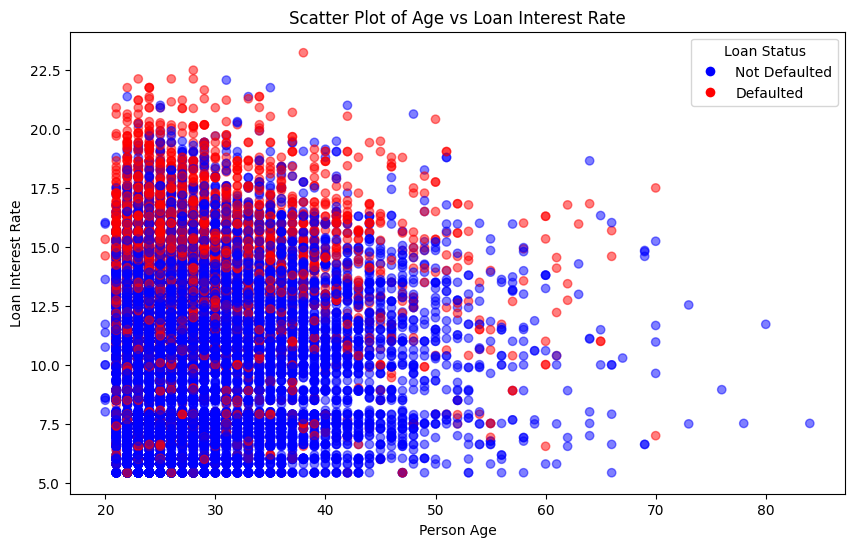

In [24]:

import matplotlib
# Define colors for the scatter plot
colors = ["blue", "red"]

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    cr_loan_cleaned['person_age'],
    cr_loan_cleaned['loan_int_rate'],
    c=cr_loan_cleaned['loan_status'],
    cmap=matplotlib.colors.ListedColormap(colors),
    alpha=0.5
)

# Add labels and title
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")
plt.title("Scatter Plot of Age vs Loan Interest Rate")

# Create a legend
legend_labels = ['Not Defaulted', 'Defaulted']  # Adjust labels as per your data
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=8) for i in range(len(colors))]
plt.legend(handles, legend_labels, title="Loan Status")

# Display the plot
plt.show()

In [25]:
cr_loan_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29461 entries, 0 to 32580
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  29461 non-null  int64  
 1   person_income               29461 non-null  int64  
 2   person_home_ownership       29461 non-null  int64  
 3   person_emp_length           29461 non-null  float64
 4   loan_intent                 29461 non-null  int64  
 5   loan_amnt                   29461 non-null  int64  
 6   loan_int_rate               29461 non-null  float64
 7   loan_status                 29461 non-null  int64  
 8   cb_person_default_on_file   29461 non-null  int64  
 9   cb_person_cred_hist_length  29461 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 2.5 MB


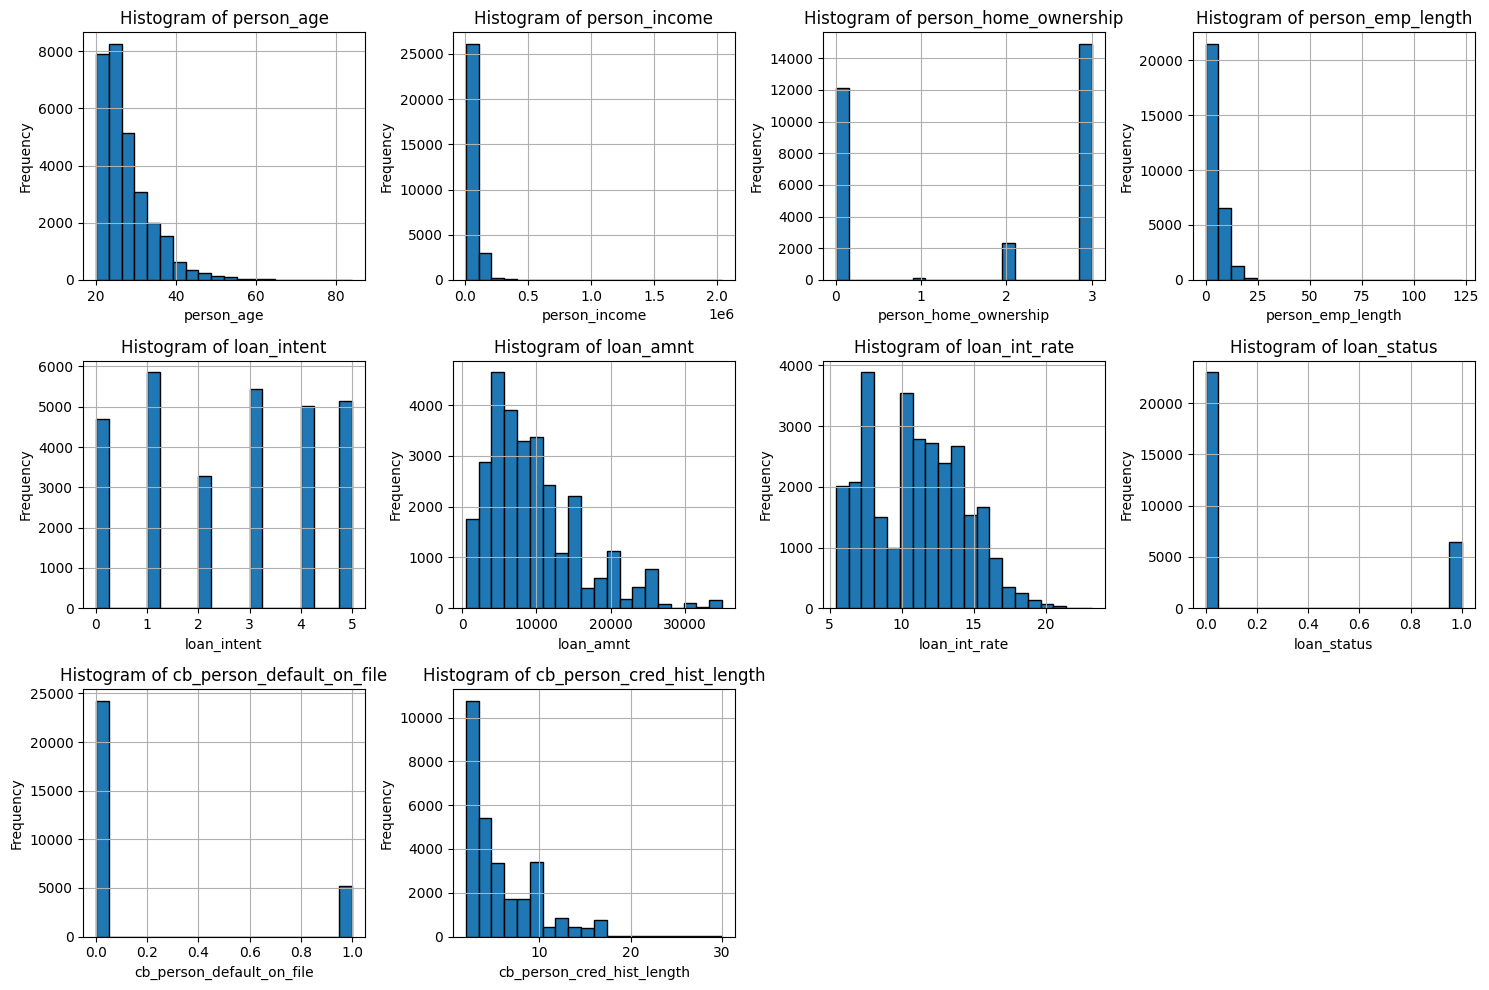

Summary Statistics for Numerical Features:
         person_age  person_income  person_home_ownership  person_emp_length  \
count  29461.000000   2.946100e+04           29461.000000       29461.000000   
mean      27.699637   6.580779e+04               1.679475           4.766437   
std        6.165419   5.133463e+04               1.432319           4.098001   
min       20.000000   4.000000e+03               0.000000           0.000000   
25%       23.000000   3.850000e+04               0.000000           2.000000   
50%       26.000000   5.500000e+04               3.000000           4.000000   
75%       30.000000   7.905000e+04               3.000000           7.000000   
max       84.000000   2.039784e+06               3.000000         123.000000   

        loan_intent     loan_amnt  loan_int_rate   loan_status  \
count  29461.000000  29461.000000   29461.000000  29461.000000   
mean       2.532059   9584.817216      11.011547      0.219409   
std        1.730237   6316.234252     

In [26]:
# Select numerical columns for histogram and summary
numerical_cols = cr_loan_cleaned.select_dtypes(include=['int64', 'float64']).columns

# Create histograms for each numerical feature
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 4, i)  # Adjust this based on the number of columns
    cr_loan_cleaned[col].hist(bins=20, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print summary statistics for each numerical column
summary_stats = cr_loan_cleaned[numerical_cols].describe()
print("Summary Statistics for Numerical Features:")
print(summary_stats)

In [27]:
cr_loan_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29461 entries, 0 to 32580
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  29461 non-null  int64  
 1   person_income               29461 non-null  int64  
 2   person_home_ownership       29461 non-null  int64  
 3   person_emp_length           29461 non-null  float64
 4   loan_intent                 29461 non-null  int64  
 5   loan_amnt                   29461 non-null  int64  
 6   loan_int_rate               29461 non-null  float64
 7   loan_status                 29461 non-null  int64  
 8   cb_person_default_on_file   29461 non-null  int64  
 9   cb_person_cred_hist_length  29461 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 2.5 MB


In [28]:
# Scale numeric features
scaler = StandardScaler()
numeric_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'cb_person_cred_hist_length']
cr_loan_cleaned[numeric_features] = scaler.fit_transform(cr_loan_cleaned[numeric_features])


In [29]:
# 2. Train-Test-Validation Split (70% train, 15% validation, 15% test)
X = cr_loan_cleaned.drop(columns=['loan_status'])
y = cr_loan_cleaned['loan_status']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [30]:
# Model Training: Logistic Regression and XGBoost with class weights

# Logistic Regression with class_weight='balanced'
log_reg_model = LogisticRegression(random_state=42, class_weight='balanced')
log_reg_model.fit(X_train, y_train)




LogisticRegression(class_weight='balanced', random_state=42)

In [31]:
# XGBoost with scale_pos_weight to handle class imbalance
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=1)  # Default scale_pos_weight works similarly for class balancing
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [32]:
# 4. Model Evaluation on Validation Set

# Logistic Regression Predictions
log_reg_probs = log_reg_model.predict_proba(X_val)[:, 1]

# XGBoost Predictions
xgb_probs = xgb_model.predict_proba(X_val)[:, 1]

# Calculate AUC for both models
log_reg_auc = roc_auc_score(y_val, log_reg_probs)
xgb_auc = roc_auc_score(y_val, xgb_probs)


In [33]:
# 5. KS Statistic and Gini Coefficient
def ks_statistic(y_true, probs):
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    ks_stat = max(tpr - fpr)
    return ks_stat

log_reg_ks = ks_statistic(y_val, log_reg_probs)
xgb_ks = ks_statistic(y_val, xgb_probs)

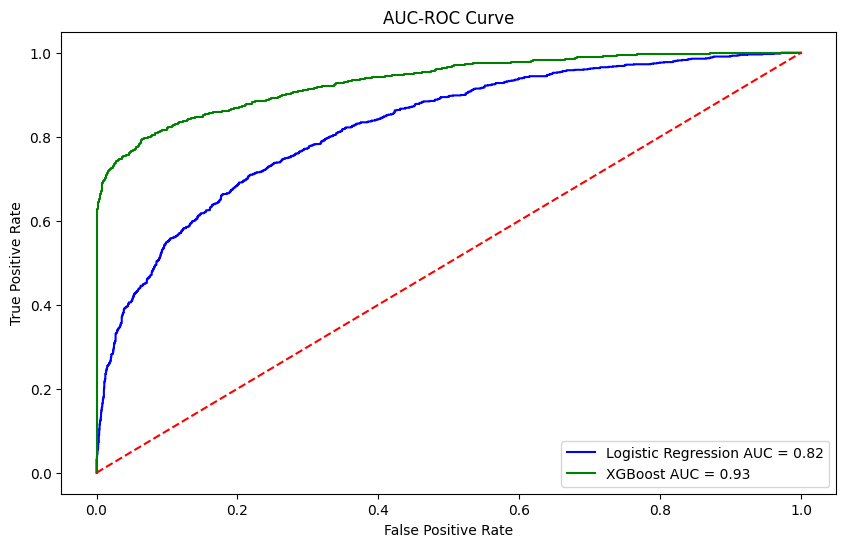

In [34]:
# Gini Coefficient (derived from AUC)
def gini_auc(auc):
    return 2 * auc - 1

log_reg_gini = gini_auc(log_reg_auc)
xgb_gini = gini_auc(xgb_auc)

# 6. Plot AUC-ROC Curves
plt.figure(figsize=(10, 6))
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_val, log_reg_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, xgb_probs)
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', label=f'Logistic Regression AUC = {log_reg_auc:.2f}')
plt.plot(fpr_xgb, tpr_xgb, color='green', label=f'XGBoost AUC = {xgb_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [35]:
# 7. Evaluate the models using the best threshold

def best_threshold(y_true, probs):
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    j_scores = tpr - fpr
    best_thresh = thresholds[np.argmax(j_scores)]
    return best_thresh


In [36]:
# Best threshold calculation
log_reg_best_thresh = best_threshold(y_val, log_reg_probs)
xgb_best_thresh = best_threshold(y_val, xgb_probs)

print(f"Logistic Regression Best Threshold: {log_reg_best_thresh:.4f}")
print(f"XGBoost Best Threshold: {xgb_best_thresh:.4f}")

Logistic Regression Best Threshold: 0.5604
XGBoost Best Threshold: 0.2473


In [37]:
# 8. Predictions and Classification Report for Best Thresholds
log_reg_preds = (log_reg_probs >= log_reg_best_thresh).astype(int)
xgb_preds = (xgb_probs >= xgb_best_thresh).astype(int)

# Logistic Regression Classification Report
print("\nLogistic Regression Classification Report (Best Threshold):")
print(classification_report(y_val, log_reg_preds))

# XGBoost Classification Report
print("\nXGBoost Classification Report (Best Threshold):")
print(classification_report(y_val, xgb_preds))


Logistic Regression Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      3435
           1       0.48      0.71      0.57       984

    accuracy                           0.77      4419
   macro avg       0.69      0.75      0.71      4419
weighted avg       0.81      0.77      0.78      4419


XGBoost Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3435
           1       0.78      0.80      0.79       984

    accuracy                           0.90      4419
   macro avg       0.86      0.87      0.86      4419
weighted avg       0.90      0.90      0.90      4419



In [38]:
# 9. Final Model Evaluation on Test Set
log_reg_test_preds = log_reg_model.predict(X_test)
xgb_test_preds = xgb_model.predict(X_test)

log_reg_accuracy = accuracy_score(y_test, log_reg_test_preds)
xgb_accuracy = accuracy_score(y_test, xgb_test_preds)

log_reg_classification_report = classification_report(y_test, log_reg_test_preds)
xgb_classification_report = classification_report(y_test, xgb_test_preds)

# 10. Print final results
print(f"Logistic Regression AUC: {log_reg_auc}")
print(f"XGBoost AUC: {xgb_auc}")
print(f"Logistic Regression KS Statistic: {log_reg_ks}")
print(f"XGBoost KS Statistic: {xgb_ks}")
print(f"Logistic Regression Gini Coefficient: {log_reg_gini}")
print(f"XGBoost Gini Coefficient: {xgb_gini}")
print(f"Logistic Regression Accuracy: {log_reg_accuracy}")
print(f"XGBoost Accuracy: {xgb_accuracy}")
print("\nLogistic Regression Classification Report:")
print(log_reg_classification_report)
print("\nXGBoost Classification Report:")
print(xgb_classification_report)

Logistic Regression AUC: 0.823074874853552
XGBoost AUC: 0.9328632205536028
Logistic Regression KS Statistic: 0.49159122377249975
XGBoost KS Statistic: 0.7302295239109596
Logistic Regression Gini Coefficient: 0.646149749707104
XGBoost Gini Coefficient: 0.8657264411072056
Logistic Regression Accuracy: 0.7230769230769231
XGBoost Accuracy: 0.9176470588235294

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      3437
           1       0.43      0.76      0.55       983

    accuracy                           0.72      4420
   macro avg       0.67      0.74      0.67      4420
weighted avg       0.80      0.72      0.74      4420


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3437
           1       0.90      0.71      0.79       983

    accuracy                           0.92      4420
   macro avg       0.9

Logistic Regression Predicted Probabilities (First 10): [0.5052479  0.60687024 0.21656466 0.28256585 0.32387602 0.18402331
 0.61955014 0.57072036 0.34730914 0.50067152]
XGBoost Predicted Probabilities (First 10): [2.0159991e-01 9.9443287e-01 2.0360896e-01 6.8600278e-04 7.1611571e-01
 4.8357811e-02 5.4292489e-02 2.7017072e-02 7.3273391e-02 9.6474020e-03]


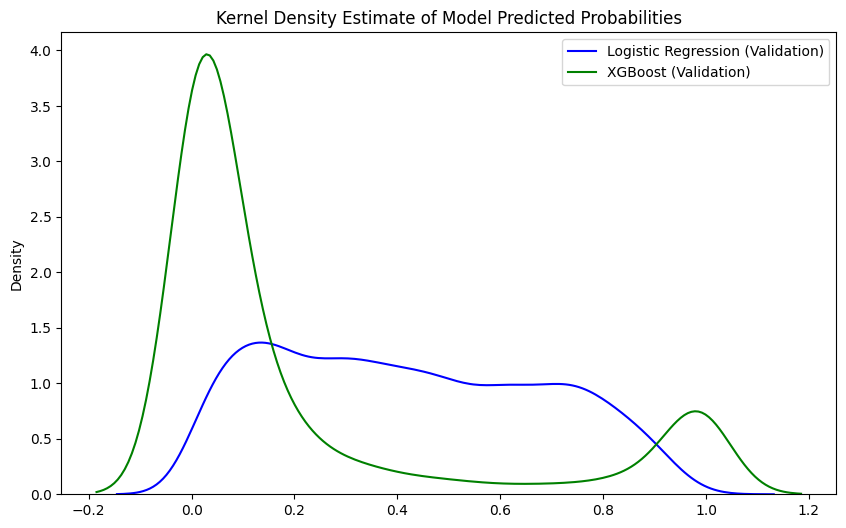

Class distribution in Training set: loan_status
0    16125
1     4497
Name: count, dtype: int64
Class distribution in Validation set: loan_status
0    3435
1     984
Name: count, dtype: int64


In [39]:
# Check the first few predicted probabilities for both models
print("Logistic Regression Predicted Probabilities (First 10):", log_reg_probs[:10])
print("XGBoost Predicted Probabilities (First 10):", xgb_probs[:10])


import seaborn as sns
plt.figure(figsize=(10, 6))
sns.kdeplot(log_reg_probs, label='Logistic Regression (Validation)', color='blue')
sns.kdeplot(xgb_probs, label='XGBoost (Validation)', color='green')
plt.title('Kernel Density Estimate of Model Predicted Probabilities')
plt.legend()
plt.show()


print("Class distribution in Training set:", y_train.value_counts())
print("Class distribution in Validation set:", y_val.value_counts())


In [40]:
# Function to calculate PSI
def calculate_psi(expected, actual, num_bins=10):
    # Create bins based on expected values (training set predictions)
    bins = np.linspace(0, 1, num_bins + 1)

    # Digitize the actual values into the bins
    expected_percents = np.histogram(expected, bins=bins, density=True)[0]
    actual_percents = np.histogram(actual, bins=bins, density=True)[0]

    # Add a small constant to avoid division by zero or log(0)
    epsilon = 1e-8
    expected_percents = np.maximum(expected_percents, epsilon)
    actual_percents = np.maximum(actual_percents, epsilon)

    # Calculate PSI for each bin
    psi_values = (actual_percents - expected_percents) * np.log(actual_percents / expected_percents)

    # Return the total PSI score
    return np.sum(psi_values)

In [41]:
log_reg_train_probs = log_reg_model.predict_proba(X_train)[:, 1]
xgb_train_probs = xgb_model.predict_proba(X_train)[:, 1]

# Calculate PSI using training set probabilities as e
log_reg_psi = calculate_psi(log_reg_train_probs, log_reg_probs)  # Training set vs Validation set for Logistic Regression
xgb_psi = calculate_psi(xgb_train_probs, xgb_probs)  # Training set vs Validation set for XGBoost

# Print the PSI values
print(f"Logistic Regression PSI: {log_reg_psi}")
print(f"XGBoost PSI: {xgb_psi}")


Logistic Regression PSI: 0.044793067443786
XGBoost PSI: 0.04535473423532044


Model Documentation
1. Dataset Overview:

The dataset (cr_loan_cleaned) consists of 29,461 entries and 10 features related to loan applications, with a focus on predicting loan status. The columns include:

person_age: Age of the applicant (int).
person_income: Income of the applicant (int).
person_home_ownership: Home ownership status of the applicant (int).
person_emp_length: Length of employment in years (float).
loan_intent: Purpose of the loan (int).
loan_amnt: Loan amount requested (int).
loan_int_rate: Interest rate of the loan (float).
loan_status: Outcome of the loan (int; 1 = Approved, 0 = Denied).
cb_person_default_on_file: Indicator if the applicant has a default on file (int).
cb_person_cred_hist_length: Length of credit history of the applicant (int).
2. Data Preprocessing:

Scaling of Numeric Features:
Used StandardScaler to normalize the following numeric features: person_age, person_income, person_emp_length, loan_amnt, loan_int_rate, and cb_person_cred_hist_length. This ensures that all numeric values are on the same scale, which is important for models like Logistic Regression and XGBoost.
3. Train-Test Split:

The dataset was split into training, validation, and test sets:

70% of the data was used for training.
15% was used for validation.
15% was used for testing.
4. Model Training:

Two models were trained to predict loan approval (loan_status):

Logistic Regression:
Class weights were balanced (class_weight='balanced') to address class imbalance.
XGBoost:
The scale_pos_weight parameter was set to 1 (default) to handle class imbalance.
Both models were trained on the training set.

5. Model Evaluation on Validation Set:

AUC-ROC (Area Under Curve - Receiver Operating Characteristic):
Logistic Regression AUC: 0.823
XGBoost AUC: 0.933
KS Statistic: Measures the maximum difference between True Positive Rate (TPR) and False Positive Rate (FPR).
Logistic Regression KS: 0.492
XGBoost KS: 0.730
Gini Coefficient: Derived from the AUC, used to assess model performance.
Logistic Regression Gini: 0.646
XGBoost Gini: 0.866
Thresholds: Best thresholds for classification were calculated using the Youden's J statistic.
Logistic Regression Threshold: 0.5604
XGBoost Threshold: 0.2473
6. Model Evaluation on Test Set:

Accuracy:
Logistic Regression: 72.31%
XGBoost: 91.76%
Classification Reports:
Logistic Regression: Precision, Recall, F1-Score calculated for each class.
XGBoost: Precision, Recall, F1-Score calculated for each class.
7. Kernel Density Estimation (KDE) of Predicted Probabilities:

KDE plots were created for the predicted probabilities of both models on the validation set, allowing a visual comparison of the two models' predicted distributions.
8. Population Stability Index (PSI):

PSI is used to measure the shift in distribution between the training and validation sets. A high PSI value indicates that the model's predictions may not generalize well.
Logistic Regression PSI: 0.0448
XGBoost PSI: 0.0454
Both PSI values indicate minimal distribution shift, suggesting that the model’s performance on the validation set is consistent with the training set.

9. Summary of Final Evaluation:

XGBoost outperforms Logistic Regression in terms of:
AUC (0.933 vs. 0.823)
KS Statistic (0.730 vs. 0.492)
Gini Coefficient (0.866 vs. 0.646)
Accuracy (91.76% vs. 72.31%)
Logistic Regression still provides useful insights but has lower performance across the board, especially in terms of recall for the minority class.
Key Findings:
Class Imbalance: Both models addressed the class imbalance problem through class weighting (Logistic Regression) and scale adjustment (XGBoost).
Model Comparison: XGBoost significantly outperforms Logistic Regression across multiple metrics.
Final Model: XGBoost is recommended for deployment in this loan prediction scenario due to its superior performance in predicting loan approvals.
Conclusion:
This analysis demonstrated the importance of model evaluation metrics such as AUC, KS Statistic, Gini Coefficient, and PSI in assessing model robustness and generalizability. The XGBoost model was found to be more effective for predicting loan approval status compared to Logistic Regression.